#### Libraries and Their Usage
- **Pandas:** For data manipulation and analysis.
- **NumPy:** For numerical computations.
- **Matplotlib & Seaborn:** For data visualization.
- **scikit-learn:** For feature extraction, dimensionality reduction, classification, and evaluation.
- **imblearn (SMOTE):** For handling imbalanced datasets.
- **LightGBM:** For advanced classification tasks.
- **spaCy & NLTK:** For text preprocessing, tokenization, and lemmatization.

#### Data Preprocessing
- Understanding missing value handling, grouping, filtering, and text preprocessing techniques (e.g., `re`, tokenization, stop word removal, lemmatization).

#### Feature Engineering
- **TF-IDF vectorization:** For converting text into numerical data.
- **Dimensionality reduction techniques:** Like PCA and t-SNE for visualizing high-dimensional data.

#### Machine Learning Concepts
- **Logistic Regression:** A classification algorithm.
- **Data Splitting:** Training and testing data for model evaluation.
- **Handling class imbalance:** Using SMOTE.

#### Evaluation Metrics
- **Confusion Matrix:** Visual representation of model performance.
- **Classification Report:** Metrics like precision, recall, F1-score.

#### Visualization Techniques
- **Count plots, bar plots, and scatter plots:** For understanding data distribution and model results.


**Medical Transcriptions Dataset Classification**

Normally, I would write long reviews and analyses, paying close attention to menu layouts. But I’ve realized that it doesn’t make much of a difference. Doing your job meticulously is no longer appreciated as it used to be. So, I’m just sharing the codes straightforwardly. Take care of yourselves!


In [1]:
import re
import json
import spacy
import openai
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
#df = pd.read_csv(r"..\LLM Engineering\LLM_Engineering\reports.csv")
df = pd.read_csv(r"C:\Users\tazeb\OneDrive\AtomicHabit\LLM Engineering\LLM_Engineering\reports.csv")
df.head()

,medical_specialty,report
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  2179 non-null   object
 1   report             2179 non-null   object
dtypes: object(2)
memory usage: 34.2+ KB


In [4]:
df = df[df["report"].notna()]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  2179 non-null   object
 1   report             2179 non-null   object
dtypes: object(2)
memory usage: 34.2+ KB


In [6]:
categories = df.groupby(df["medical_specialty"])

In [7]:
i = 1
for category_name, category in categories:
    print(f"Category_{i}, {category_name}: {len(category)}")
    i = i+1

Category_1, Cardiovascular / Pulmonary: 371
Category_2, Gastroenterology: 224
Category_3, Neurology: 223
Category_4, Radiology: 273
Category_5, Surgery: 1088


In [8]:
df_filtered = categories.filter(lambda x: x.shape[0] > 10)
# Select the categories with more than 10 reports/rows

In [9]:
df_openai = df_filtered.copy()

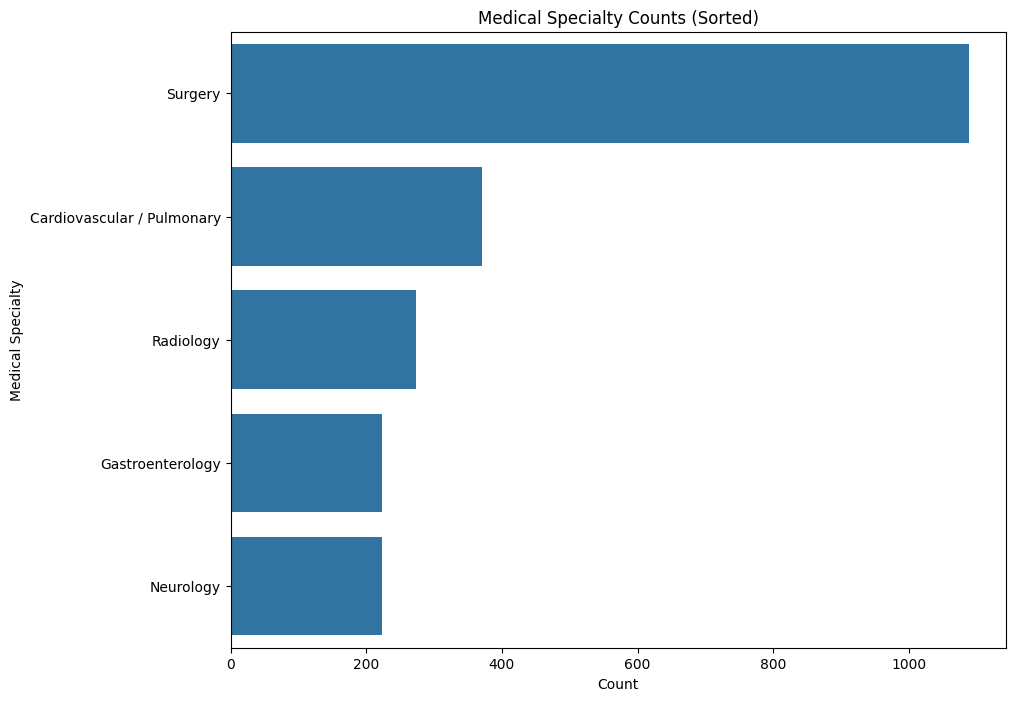

In [10]:
ordered_specialties = df_filtered['medical_specialty'].value_counts().index
plt.figure(figsize = (10, 8))
sns.countplot(y = "medical_specialty", data = df_filtered, order = ordered_specialties)
plt.title("Medical Specialty Counts (Sorted)")
plt.xlabel("Count")
plt.ylabel("Medical Specialty")
plt.show()

In [11]:
df.isna().sum()

medical_specialty    0
report               0
dtype: int64

In [12]:
nlp = spacy.load('en_core_web_sm')
def clean_text(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    doc = nlp(text)
    text = ' '.join(token.lemma_ for token in doc if token.text.lower() not in STOP_WORDS and token.is_alpha)
    return text

In [13]:
df['cleaned_transcription'] = df['report'].apply(clean_text)

In [14]:
df.head()

,medical_specialty,report,cleaned_transcription
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...",M MODE leave atrial enlargement left atrial di...
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,left ventricular cavity size wall thickness ap...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",ECHOCARDIOGRAM multiple view heart great vesse...
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....",description normal cardiac chamber size normal...
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...",study mild aortic stenosis widely calcify mini...


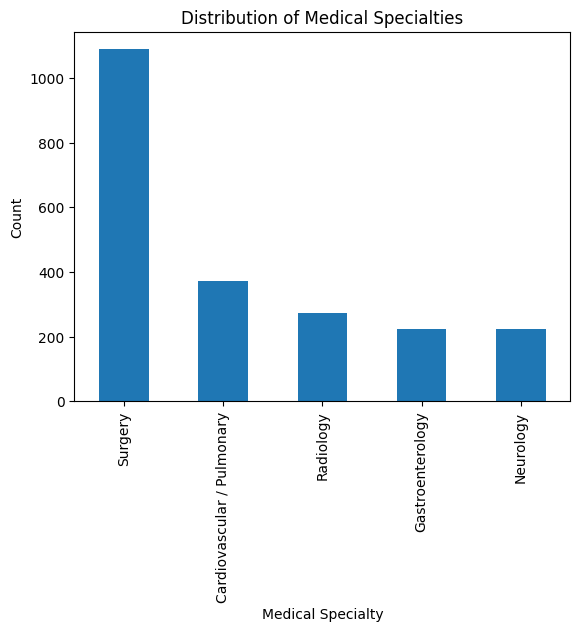

In [15]:
import matplotlib.pyplot as plt
df['medical_specialty'].value_counts().plot(kind = 'bar')
plt.title('Distribution of Medical Specialties')
plt.xlabel('Medical Specialty')
plt.ylabel('Count')
plt.show()


### Code below explanations ...
### 1. TF-IDF Vectorization
        tfidf_vectorizer = TfidfVectorizer(max_features=1000)
        tfidf_matrix = tfidf_vectorizer.fit_transform(df_filtered['cleaned_transcription'])

#### What It Does:
* **TfidfVectorizer:**
    - Converts text data (cleaned_transcription) into numerical features using Term Frequency-Inverse Document Frequency (TF-IDF).
    - TF-IDF captures how important a word is in a document relative to the entire dataset.
* max_features = 1000:
    - Limits the number of features (unique terms) to the top 1,000 most important terms.
* Result:
    - tfidf_matrix: A sparse matrix where rows represent documents (transcriptions) and columns represent terms (features), with each value indicating the importance of a term in a document.

### 2. Encoding Labels
        labels = df_filtered['medical_specialty'].astype('category').cat.codes
#### What It Does:
* Converts the medical_specialty column (categorical data) into numerical labels.
* astype('category'): Treats the column as a categorical variable.
* cat.codes: Assigns a unique numerical code to each category (e.g., Cardiology → 0, Radiology → 1, etc.).
#### Result:
* labels: A numerical array representing the medical specialties for each record.

### 3. Setting Up t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)

#### What It Does:
* TSNE (t-Distributed Stochastic Neighbor Embedding):
    - A dimensionality reduction algorithm used to map high-dimensional data into 2D or 3D space for visualization.
    - Focuses on preserving local relationships (points that are close in high-dimensional space remain close in 2D/3D).
* Key Parameters:
    - n_components=2: Reduces the data to 2 dimensions for visualization.
    - random_state=42: Ensures reproducibility of results.
    - perplexity=30: Controls how the algorithm balances local and global aspects of the data (optimal value depends on dataset size and complexity).
### 4. Applying t-SNE
        tsne_result = tsne.fit_transform(tfidf_matrix.toarray())
#### What It Does:
* fit_transform:
* Applies the t-SNE algorithm to the dense TF-IDF matrix (converted to an array with .toarray()).
#### Result:
* tsne_result: A 2D array where each row represents the transformed coordinates (Dimension 1 and Dimension 2) of a document in the 2D space.

### 5. Creating a DataFrame
        tsne_df = pd.DataFrame(tsne_result, columns=['Dimension 1', 'Dimension 2'])
        tsne_df['Medical Specialty'] = df_filtered['medical_specialty']
#### What It Does:
* Creates a DataFrame: Combines the 2D coordinates from t-SNE (tsne_result) with the corresponding medical specialty labels.
* Columns:
    - Dimension 1: The first dimension of the t-SNE-transformed data.
    - Dimension 2: The second dimension.
    - Medical Specialty: The original category of the transcription.
* Result:
    - tsne_df: A structured DataFrame that can be directly used for visualization



In [16]:
text_data = df['cleaned_transcription']
tfidf_vectorizer = TfidfVectorizer(max_features = 1000)  
tfidf = tfidf_vectorizer.fit_transform(text_data)

tfidf_dense = tfidf.toarray()
labels = df['medical_specialty'].astype('category').cat.codes

tsne = TSNE(n_components = 2, random_state = 42, init = 'random', perplexity = 30)
tsne_result = tsne.fit_transform(tfidf_dense)

In [17]:
tsne_result

array([[ -4.1023726, -60.446724 ],
       [ -1.8827872, -60.39237  ],
       [  3.8359704, -57.72301  ],
       ...,
       [-37.89744  , -47.616375 ],
       [-37.695328 , -48.211124 ],
       [-22.181221 , -40.54717  ]], dtype=float32)

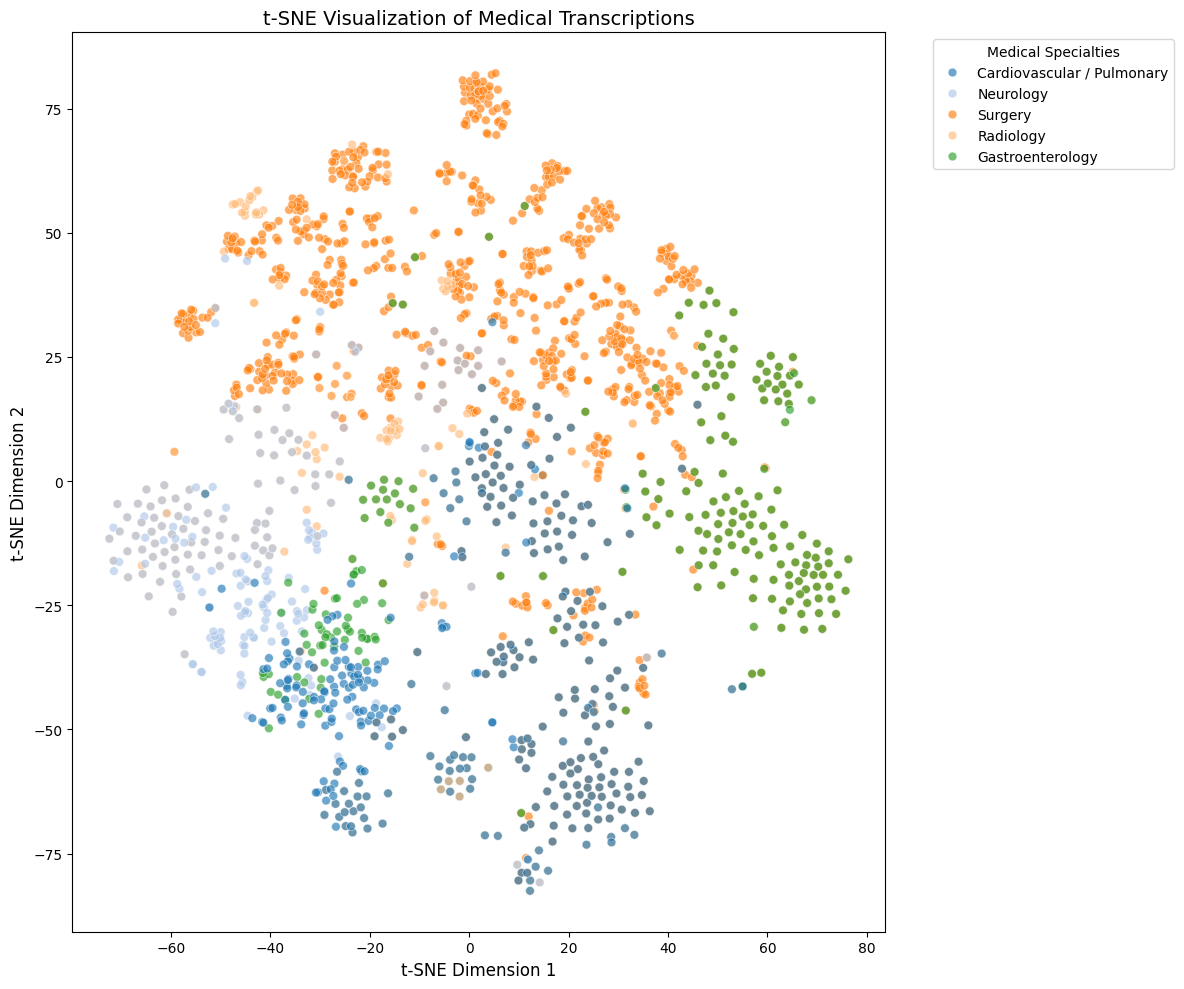

In [18]:
tsne_df = pd.DataFrame(tsne_result, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Medical Specialty'] = df['medical_specialty']  

plt.figure(figsize = (12, 10))
sns.scatterplot(
    data = tsne_df,
    x = 'Dimension 1',
    y = 'Dimension 2',
    hue = 'Medical Specialty',  
    palette = 'tab20', 
    alpha = 0.65,
    s = 40  
)

plt.title('t-SNE Visualization of Medical Transcriptions', fontsize = 14)
plt.xlabel('t-SNE Dimension 1', fontsize = 12)
plt.ylabel('t-SNE Dimension 2', fontsize = 12)
plt.legend(title = 'Medical Specialties', bbox_to_anchor = (1.05, 1), loc = 'upper left', fontsize = 10) 
plt.tight_layout()
plt.show()


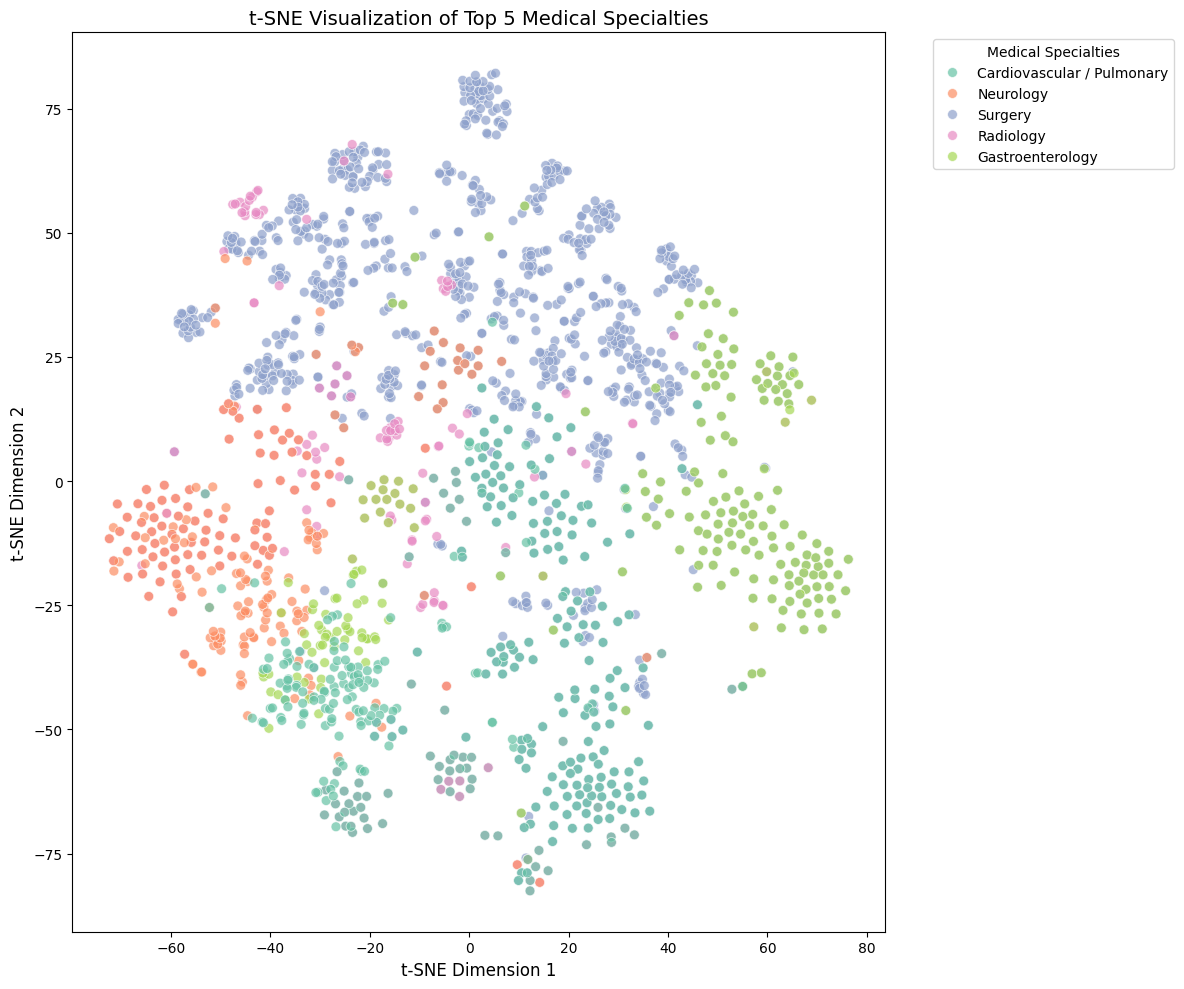

In [19]:
top_categories = df['medical_specialty'].value_counts().head(5).index
filtered_data = df[df['medical_specialty'].isin(top_categories)]
filtered_tfidf = tfidf_vectorizer.fit_transform(filtered_data['cleaned_transcription'])
filtered_tfidf_dense = filtered_tfidf.toarray()

tsne = TSNE(n_components=2, random_state=42, init='random', perplexity=30)
filtered_tsne_result = tsne.fit_transform(filtered_tfidf_dense)

filtered_tsne_df = pd.DataFrame(filtered_tsne_result, columns=['Dimension 1', 'Dimension 2'])
filtered_tsne_df['Medical Specialty'] = filtered_data['medical_specialty'].values

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=filtered_tsne_df,
    x='Dimension 1',
    y='Dimension 2',
    hue='Medical Specialty',
    palette='Set2',
    alpha=0.7,
    s=50
)

plt.title('t-SNE Visualization of Top 5 Medical Specialties', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.legend(title='Medical Specialties', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()


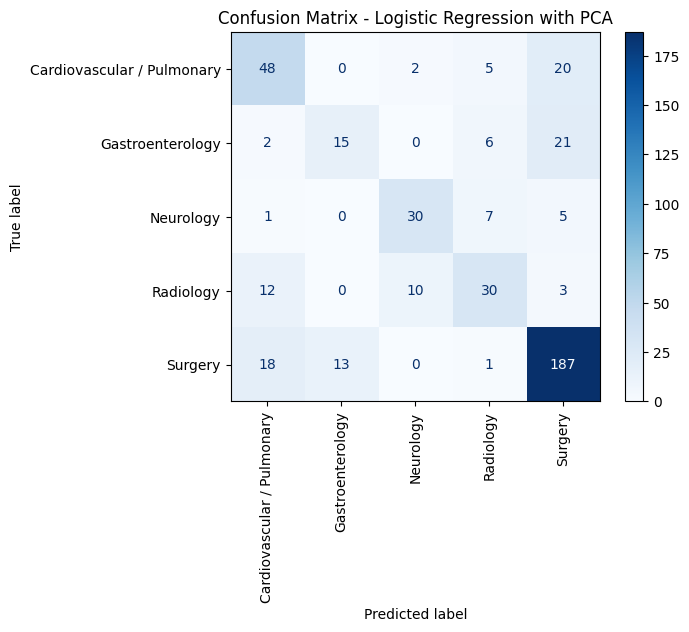

Classification Report:
                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.59      0.64      0.62        75
          Gastroenterology       0.54      0.34      0.42        44
                 Neurology       0.71      0.70      0.71        43
                 Radiology       0.61      0.55      0.58        55
                   Surgery       0.79      0.85      0.82       219

                  accuracy                           0.71       436
                 macro avg       0.65      0.62      0.63       436
              weighted avg       0.70      0.71      0.70       436



In [20]:
top_categories = df['medical_specialty'].value_counts().head(5).index
df = df[df['medical_specialty'].isin(top_categories)]

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_transcription'])

pca = PCA(n_components=50, random_state=42)
pca_transformed = pca.fit_transform(tfidf_matrix.toarray())
labels = df['medical_specialty'].astype('category').cat.codes
X_train, X_test, y_train, y_test = train_test_split(pca_transformed, labels, test_size = 0.2, random_state = 42)
lr_model = LogisticRegression(random_state = 42, max_iter = 1000)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)


conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df['medical_specialty'].astype('category').cat.categories)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - Logistic Regression with PCA")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=df['medical_specialty'].astype('category').cat.categories))


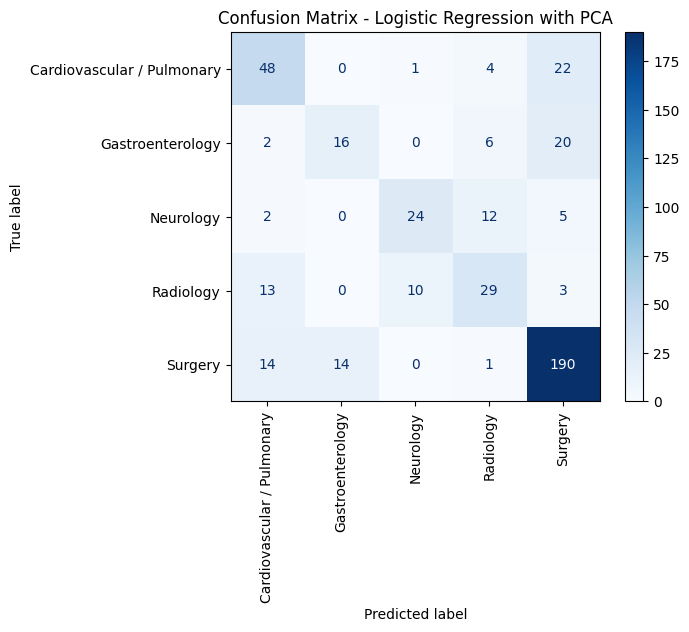

Classification Report:
                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.61      0.64      0.62        75
          Gastroenterology       0.53      0.36      0.43        44
                 Neurology       0.69      0.56      0.62        43
                 Radiology       0.56      0.53      0.54        55
                   Surgery       0.79      0.87      0.83       219

                  accuracy                           0.70       436
                 macro avg       0.64      0.59      0.61       436
              weighted avg       0.69      0.70      0.70       436



In [21]:
top_categories = df['medical_specialty'].value_counts().head(5).index
df = df[df['medical_specialty'].isin(top_categories)]

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_transcription'])

pca = PCA(n_components=100, random_state=42)
pca_transformed = pca.fit_transform(tfidf_matrix.toarray())

labels = df['medical_specialty'].astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(pca_transformed, labels, test_size=0.2, random_state=42)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)


conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=df['medical_specialty'].astype('category').cat.categories)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix - Logistic Regression with PCA")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=df['medical_specialty'].astype('category').cat.categories))


# Confusion Matrix Analysis

## Definitions for Each Class
For a given class \( C \):
- **True Positives (TP):** Cases where the model correctly predicted class \( C \).
- **False Positives (FP):** Cases where the model incorrectly predicted class \( C \), but the true label was something else.
- **False Negatives (FN):** Cases where the model failed to predict class \( C \), even though the true label was \( C \).
- **True Negatives (TN):** All other cases that are neither \( TP \), \( FP \), nor \( FN \).

---

## Analysis by Class

### 1. Cardiovascular/Pulmonary
- **TP:** 48 (correctly predicted as Cardiovascular/Pulmonary)
- **FP:** \( 2 + 2 + 13 + 15 = 32 \) (other classes misclassified as Cardiovascular/Pulmonary)
- **FN:** \( 1 + 4 + 22 = 27 \) (Cardiovascular/Pulmonary misclassified as other classes)
- **TN:** \( 480 - (48 + 32 + 27) = 373 \)

### 2. Gastroenterology
- **TP:** 16 (correctly predicted as Gastroenterology)
- **FP:** \( 0 + 0 + 0 + 14 = 14 \) (other classes misclassified as Gastroenterology)
- **FN:** \( 2 + 6 + 20 = 28 \) (Gastroenterology misclassified as other classes)
- **TN:** \( 480 - (16 + 14 + 28) = 422 \)

### 3. Neurology
- **TP:** 24 (correctly predicted as Neurology)
- **FP:** \( 1 + 0 + 10 + 0 = 11 \) (other classes misclassified as Neurology)
- **FN:** \( 2 + 12 + 5 = 19 \) (Neurology misclassified as other classes)
- **TN:** \( 480 - (24 + 11 + 19) = 426 \)

### 4. Radiology
- **TP:** 29 (correctly predicted as Radiology)
- **FP:** \( 4 + 6 + 12 + 1 = 23 \) (other classes misclassified as Radiology)
- **FN:** \( 13 + 10 + 3 = 26 \) (Radiology misclassified as other classes)
- **TN:** \( 480 - (29 + 23 + 26) = 402 \)

### 5. Surgery
- **TP:** 189 (correctly predicted as Surgery)
- **FP:** \( 22 + 20 + 5 + 3 = 50 \) (other classes misclassified as Surgery)
- **FN:** \( 15 + 14 + 0 + 1 = 30 \) (Surgery misclassified as other classes)
- **TN:** \( 480 - (189 + 50 + 30) = 211 \)

---

## Summary Table

| Class                     | TP  | FP  | FN  | TN  |
|---------------------------|------|------|------|------|
| **Cardiovascular/Pulmonary** | 48   | 32   | 27   | 373  |
| **Gastroenterology**        | 16   | 14   | 28   | 422  |
| **Neurology**              | 24   | 11   | 19   | 426  |
| **Radiology**              | 29   | 23   | 26   | 402  |
| **Surgery**                | 189  | 50   | 30   | 211  |

---

## Insights
1. **True Positives (TP):**
   - High TP for "Surgery" (189) indicates strong performance for this class.
   - Low TP for "Gastroenterology" (16) suggests difficulty in identifying this class.

2. **False Positives (FP):**
   - "Surgery" has the highest FP (50), meaning other classes are often misclassified as "Surgery."
   - "Gastroenterology" has a relatively low FP (14), indicating fewer misclassifications from other classes.

3. **False Negatives (FN):**
   - "Gastroenterology" and "Radiology" have the highest FN values (28 and 26), indicating many true cases are misclassified.

4. **True Negatives (TN):**
   - Higher TN values (e.g., 426 for Neurology) suggest fewer overall misclassifications for this class.

---

## Recommendations for Improvement
1. **Balance the Dataset**:
   - Address class imbalance using oversampling, undersampling, or class-weighted algorithms.

2. **Feature Engineering**:
   - Improve features using n-grams or domain-specific embeddings to better capture distinctions between classes.

3. **Try Advanced Models**:
   - Experiment with ensemble methods like Random Forest, LightGBM, or deep learning models.

4. **Analyze Misclassifications**:
   - Investigate why certain classes (e.g., Gastroenterology) are often confused with others, and address feature overlap.



# GenAI Integration for Fine-Tuning

In [22]:
df_openai["medical_specialty"].value_counts()

medical_specialty
Surgery                       1088
Cardiovascular / Pulmonary     371
Radiology                      273
Gastroenterology               224
Neurology                      223
Name: count, dtype: int64

In [23]:
# Train-Test Split
grouped_data = df_openai.groupby("medical_specialty").sample(223, random_state = 42)
val_test_data = grouped_data.groupby("medical_specialty").sample(30, random_state = 42)
val = val_test_data.groupby("medical_specialty").head(15)
test = val_test_data.groupby("medical_specialty").tail(15)
train = grouped_data[~grouped_data.index.isin(val_test_data.index)]

In [24]:
# System prompt for fine-tuning
system_prompt = """Given the medical description report, classify it into one of these categories: 
                    [Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery]"""

# Function to format data for fine-tuning
def df_to_format(df):
    formatted_data = []
    for _, row in df.iterrows():
        entry = {
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": row["report"]},
                {"role": "assistant", "content": row["medical_specialty"]}
            ]
        }
        formatted_data.append(entry)
    return formatted_data

# Prepare fine-tuning data
train_data = df_to_format(train)
train_file_path = r"C:\Users\tazeb\OneDrive\AtomicHabit\LLM Engineering\LLM_Engineering\fine_tuning_data.jsonl"
with open(train_file_path, 'w') as f:
    for entry in train_data:
        f.write(json.dumps(entry))
        f.write("\n")

val_data = df_to_format(val)
val_file_path = r"C:\Users\tazeb\OneDrive\AtomicHabit\LLM Engineering\LLM_Engineering\fine_tuning_data_val.jsonl"
with open(val_file_path, 'w') as f:
    for entry in val_data:
        f.write(json.dumps(entry))
        f.write("\n")

client = openai.OpenAI()
# Upload train file
with open(train_file_path, "rb") as train_file:
    train_upload_response = client.files.create(file=train_file, purpose="fine-tune")

# Upload validation file
with open(val_file_path, "rb") as val_file:
    val_upload_response = client.files.create(file=val_file, purpose="fine-tune")

print("Train File Upload Response:", train_upload_response)
print("Validation File Upload Response:", val_upload_response)

Train File Upload Response: FileObject(id='file-2wJvayWPndcVYF2QT4T4cu', bytes=2916657, created_at=1738774665, filename='fine_tuning_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)
Validation File Upload Response: FileObject(id='file-5F1BY2x7wim4sdbH8JdEzz', bytes=220492, created_at=1738774666, filename='fine_tuning_data_val.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)


In [25]:
fine_tuning_response = client.fine_tuning.jobs.create(
    training_file=train_upload_response.id,
    model="gpt-3.5-turbo",  # ✅ GPT-3.5-turbo is supported
    hyperparameters={'n_epochs': 1}
)

In [26]:
import time
fine_tuning_job_id = fine_tuning_response.id 
# Monitor fine-tuning progress
while True:
    fine_tuning_status = client.fine_tuning.jobs.retrieve(fine_tuning_job_id)    
    print(f"Fine-tuning status: {fine_tuning_status.status}")  
    if fine_tuning_status.status in ["succeeded", "failed", "cancelled"]:
        break  # Exit when fine-tuning completes
    time.sleep(30)  # Wait before checking again

Fine-tuning status: validating_files
Fine-tuning status: validating_files
Fine-tuning status: validating_files
Fine-tuning status: validating_files
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning status: running
Fine-tuning 

In [27]:
import matplotlib.pyplot as plt

# Initialize lists to store metrics
train_loss = []
steps = []

# Extract data only from 'metrics' type events
for event in logs.data:
    if event.type == "metrics" and "train_loss" in event.data:
        train_loss.append(event.data["train_loss"])
        steps.append(event.data["step"])  # Use the actual step from the event

# Plotting
if train_loss:
    plt.figure(figsize=(10, 5))
    plt.plot(steps, train_loss, label="Training Loss", marker='o')

    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Fine-Tuning Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("No training data available for plotting.")


NameError: name 'logs' is not defined